<a href="https://colab.research.google.com/github/Molten-Ice/de-identification/blob/colab/dev-notebooks/16-end-to-end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Apr 28 20:54:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!git clone -b main --single-branch https://github.com/Molten-Ice/de-identification.git
pip install -r requirements.txt
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch
!wget -P /content/ https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

#Sample image
!wget https://raw.githubusercontent.com/Molten-Ice/Deep-Learning/main/Data/16070.jpg

Cloning into 'de-identification'...
remote: Enumerating objects: 306, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 306 (delta 37), reused 30 (delta 6), pack-reused 203
Receiving objects: 100% (306/306), 326.26 MiB | 18.68 MiB/s, done.
Resolving deltas: 100% (101/101), done.
Updating files: 100% (75/75), done.


In [ ]:
import os
import cv2
import time
import math
import torch
import pickle
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
from PIL import Image, ImageOps
from deepface import DeepFace
from facenet_pytorch import MTCNN
import torchvision.transforms as transforms

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, repo_dir + 'stylegan2-ada-pytorch')
import dnnlib
import torch_utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
assert device.type == "cuda", "Error, not running on gpu!"

In [76]:
# The initial running of this code cell takes quite some time
### Setting up plugins & downloading model weights for stylegan2-ada-pytorch & deepface ###

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device)  # torch.nn.Module
# First time running through sets up pluggins and takes a few minutes, after that takes < 1 second
z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
output = D(img, None)

Image.fromarray(np.random.randint(0, high=255, size=(408, 612, 3), dtype=np.uint8)).save('dummy_image.jpg')
objs = DeepFace.analyze(img_path = 'dummy_image.jpg', actions = ['age', 'gender', 'race'], enforce_detection = False)

Action: race: 100%|██████████| 3/3 [00:00<00:00, 11.79it/s]


G parameters: 30,370,060 | D Parameters: 29,012,513


In [96]:
def tensor_to_np(img):
    """Torch tensor -> normalized np image"""
    torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True, padding = 0)
    return np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)

def display_and_concat(images,size = (500,500)):
    images_to_concat = []
    for image in images:
        images_to_concat.append(tensor_to_np(image))
    display_img = np.concatenate(images_to_concat,axis=1)
    display(ImageOps.contain(Image.fromarray(display_img), size))

def generate_boxes_landmarks(img, mtcnn, device):
    all_boxes, all_probs, all_landmarks = mtcnn.detect(torch.Tensor(img).to(device), landmarks=True)
    if all_boxes is None: return [], [], []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    all_landmarks = [[[int(x), int(y)] for x, y in point] for point in all_landmarks] 

    boxes, probs, landmarks, centres = [], [], [], []
    threshold = 0.9
    for box, prob, landmark in zip(all_boxes, all_probs, all_landmarks):
            if prob >= threshold:
                boxes.append(box)
                probs.append(prob)
                landmarks.append(landmark)
    # print(f"[{len(boxes)}/{len(all_boxes)}] faces used")
    return boxes, landmarks, probs

def generate_face_traits(original_img, raw_boxes):
    #find face traits
    faces_traits = [] 
    idx = 0
    while idx < len(raw_boxes):
        img_copy = original_img.copy()
        box = raw_boxes[idx]
        cropped_img = img_copy[box[1]:box[3], box[0]:box[2]]
        cv2.imwrite("temp.jpg", cropped_img)
        generated_traits = DeepFace.analyze(img_path = "temp.jpg", actions = ['age', 'gender', 'race'], enforce_detection = False, silent = True)
        faces_traits.append(generated_traits[0])
        idx+=1
    return faces_traits

def poisson_blend(paste_image, source_img, box):
    """ Poisson blending using seamlessClone
    blends paste_image into source_image
    """
    src_mask = np.zeros(paste_image.shape, paste_image.dtype)
    height,width = paste_image.shape[:2]

    rectangle = np.array([
        [0, 0], 
        [0, height],
        [width, height],
        [width, 0]], np.int32)
    cv2.fillPoly(src_mask, [rectangle], (255, 255, 255))

    box_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]
    blended = cv2.seamlessClone(paste_image, source_img, src_mask, box_centre, cv2.NORMAL_CLONE)
    return blended

def find_best_zs(mtcnn, G, real_traits, max_iterations = 50, samples_wanted = 3, silent = True):
    best_zs = [] # [(age diff, z),...]
    for i in range(max_iterations):
        if len(best_zs) == samples_wanted:
            break
        z = torch.randn([1, G.z_dim]).to(device) # 512 latent vector                  
        img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
        torch_grid = torchvision.utils.make_grid(img.cpu(), normalize = True)
        np_img = np.ascontiguousarray((torch_grid.permute(1,2,0).numpy()*255), dtype=np.uint8)
        boxes, landmarks, probs = generate_boxes_landmarks(np_img, mtcnn, device)
        if len(boxes) == 0:
            # print("No faces found!! skip example")
            continue

        box_generated = boxes[0]
        display_img = np_img[box_generated[1]:box_generated[3], box_generated[0]:box_generated[2]]
        cv2.imwrite("temp.jpg", display_img)
        generated_traits = DeepFace.analyze(img_path = "temp.jpg", actions = ['age', 'gender', 'race'], enforce_detection = False, silent = silent)
        matching = True
        for key in ['dominant_gender', 'dominant_race']:
            if real_traits[key] != generated_traits[0][key]:
                # print(f"Not matching on: {key}")
                matching = False
                break

        if not matching: continue
        # display(ImageOps.contain(Image.fromarray(np_img), (400, 400)))

        age_diff = abs(real_traits['age'] - generated_traits[0]['age'])
        best_zs.append([age_diff, z, box_generated])
    # best_zs = sorted(best_zs, key=lambda x: x[0], reverse=False)
    # print(f"[{len(best_zs)}/{samples_wanted}] generated in {i} iterations")
    return best_zs

def create_training_masks_targets(best_zs, real_face, border_factor = 0.15):
    tensor_transform = transforms.ToTensor()
    training_images = []
    for _, z, box in best_zs: 
        #Generate image
        img = G(z, None)  # NCHW, float32, dynamic range [-1, +1], None is class labels
        np_generated = tensor_to_np(img)
        # display(ImageOps.contain(Image.fromarray(np_generated), (400, 400)))

        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1

        #Create a mask of the cropped image's border
        border_width = int(width*border_factor)
        border_height = int(height*border_factor)
        mask = torch.zeros((1, 3, 1024, 1024)).to(device)
        mask[:, :, y1:y2, x1:x2] = 1
        mask[:, :, y1+border_height:y2-border_height, x1+border_width:x2-border_width] = 0
        
        # resize original face to generated face's size
        resized_face = cv2.resize(real_face.copy(), [width, height])

        #convert image to torch tensor, place face aligned in 1024x1024 square
        real_face_tensor = torch.zeros((1, 3, 1024, 1024)).to(device)
        real_face_tensor[:, :, y1:y2, x1:x2] = tensor_transform(resized_face).unsqueeze(dim=0).to(device)
        training_images.append([z, box, real_face_tensor, mask, real_face])
        
    return training_images

def train_loop(training_images, track_progress = 50, eval_interval = 50,  iterations = 800):
    """
    Set track_progress/eval_interval to 0 to not record/display
    """
    zs = [array[0] for array in training_images]
    fixed_noise = torch.cat(zs, dim=0).clone().requires_grad_(True) #512 input latent vector

    lr = 0.003
    lam = 0.0005 # perceptual_loss factor
    
    progress = []

    # criterion = nn.BCELoss()
    optimizer = optim.Adam([fixed_noise], lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, iterations)

    t_start = time.time()
    for i in range(iterations):
        fake_faces = G(fixed_noise, None)
        perceptual_loss = torch.sum(D(fake_faces, None).view(-1))# unbounded, the more negative, the more confident D is that it's real
        
        contextual_losses = []
        for face_idx, (_, _, real_face_tensor, mask, _) in enumerate(training_images):
            fake_face = fake_faces[face_idx].unsqueeze(dim=0)
            contextual_loss_singular = nn.functional.l1_loss(real_face_tensor*mask, fake_face*mask)
            contextual_losses.append(contextual_loss_singular)
        contextual_loss = sum(contextual_losses)
        
        complete_loss = contextual_loss + lam*perceptual_loss

        optimizer.zero_grad()
        complete_loss.backward()
        optimizer.step()
        scheduler.step()

        if eval_interval != 0 and i % eval_interval == 0:
            print(f"Losses, {i} iteration:: Complete:{complete_loss:.4f}, contextual:{contextual_loss:.4f},  perceptual original: {perceptual_loss:.4f}, perceptual (after x{lam}): {lam*perceptual_loss:.4f} ,, time: {time.time()-t_start:.2f}s")
        if track_progress != 0 and i % track_progress == 0:
            progress.append(fake_faces.clone().cpu())   

    print(f"Generation finished for {len(training_images)} in {time.time()-t_start:.2f} seconds")
    return fake_faces, fixed_noise, progress


def calculate_rotate_angle(left_eye, right_eye):

    if left_eye[1] > right_eye[1]: # right eye higher than left eye
        # print("rotating clockwise")
        direction = -1
        third_point = (right_eye[0], left_eye[1])
    else:
        # print("rotating counter-clockwise")
        direction = 1
        third_point = (left_eye[0], right_eye[1])

    def euclidean_distance(a, b):
        return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)
    a = euclidean_distance(left_eye, third_point)
    b = euclidean_distance(right_eye, left_eye)
    c = euclidean_distance(right_eye, third_point)
    angle = np.degrees(np.arccos((b*b + c*c - a*a)/(2*b*c)))

    if direction == -1:
        angle = 90 - angle

    rotate_angle = direction * angle
    return rotate_angle

def find_new_bbox_cords(mtcnn, rotated_img, face_centre):
    new_boxes, new_landmarks, new_probs = generate_boxes_landmarks(rotated_img, mtcnn, device)
    boxes_distances = []
    for new_box, new_landmark in zip(new_boxes, new_landmarks):
        centre = [(new_box[0] + new_box[2])//2, (new_box[1] + new_box[3])//2]
        difference = abs(np.array(centre) - np.array(face_centre)).mean()
        boxes_distances.append([difference, new_box])
    if len(boxes_distances) == 0: 
        return []
    boxes_distances.sort(key=lambda x: x[0])
    wanted_box = boxes_distances[0][1]
    return wanted_box


def generate_align_rotated_faces(original_img, raw_boxes, raw_landmarks):
    boxes = [[x+pad_width for x in box] for box in raw_boxes]
    landmarks = [[[point[0]+pad_width, point[1]+pad_width] for point in landmark] for landmark in raw_landmarks]

    cropped_faces = []
    for box, landmark in zip(boxes, landmarks):
        left_eye, right_eye = landmark[0], landmark[1]
        face_centre = [(box[0] + box[2])//2, (box[1] + box[3])//2]

        # work with padded image to ensure during rotation the face does not leave the image
        original_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
        original_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()

        rotate_angle = calculate_rotate_angle(left_eye, right_eye)
        rotated_img = np.array(Image.fromarray(original_img_padded).rotate(rotate_angle, center=face_centre, expand=False))
        rotated_box = find_new_bbox_cords(mtcnn, rotated_img, face_centre)

        cropped_face = rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]].copy()
        cropped_faces.append([cropped_face, box, rotated_box, rotated_img, rotate_angle, face_centre])
    return cropped_faces

def generate_training_image(cropped_faces, face_traits):
    indexes = []
    training_images = []
    for real_face_array, traits in zip(cropped_faces, face_traits):
        real_face = real_face_array[0]
        best_zs_for_face = find_best_zs(mtcnn, G, traits, max_iterations = 50, samples_wanted = 1)
        training_images_for_face = create_training_masks_targets(best_zs_for_face, real_face, border_factor = border_factor)
        indexes.append([len(training_images), len(training_images)+len(training_images_for_face)])
        training_images.extend(training_images_for_face)
    return training_images, indexes


def poisson_blend_generated_faces(training_images, indexes):
    generated_faces = []
    # print("Original Face -> Random generated -> Inpainting -> Poisson Blended")
    for index in indexes:
        # print("Generations for different face:")
        outputs_for_face = []
        for z_idx in range(*index):
            z, box, real_face_tensor, mask, real_face = training_images[z_idx]
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            #Create a mask of the cropped image's border
            border_width = int(width*border_factor)
            border_height = int(height*border_factor)

            # resize original face to generated face's size
            resized_face = cv2.resize(real_face, [width, height])
            centre_box = [0, 0, resized_face.shape[1], resized_face.shape[0]]

            generated_face = fake_faces[z_idx].unsqueeze(dim=0)
            np_generated = tensor_to_np(generated_face)
            paste_image = np_generated[y1+border_height:y2-border_height, x1+border_width:x2-border_width]
            blended = poisson_blend(paste_image, resized_face, centre_box)

            original_generated = G(z, None) 
            original_masked_img = tensor_to_np(real_face_tensor*mask + original_generated*(1-mask))[y1:y2, x1:x2]
            raw_masked_img = tensor_to_np(real_face_tensor*mask + generated_face*(1-mask))[y1:y2, x1:x2]
            
            display_img = np.concatenate([resized_face, original_masked_img, raw_masked_img, blended],axis=1)
            # display(ImageOps.contain(Image.fromarray(display_img), (800, 800)))

            output_face = cv2.resize(blended, [real_face.shape[1], real_face.shape[0]])#shape order defo messed up
            outputs_for_face.append(output_face)
            # display(Image.fromarray(output_face))

        #Use discriminator to pick best option here - doesn't actually work lol ;(
        # tensor_transform = transforms.ToTensor()
        # best_loss = 0
        # best_face = None
        # for possible_face in outputs_for_face:
        #     tensor_image = torch.zeros((1, 3, 1024, 1024)).to(device)
        #     np_image = np.array(ImageOps.contain(Image.fromarray(possible_face), (1024, 1024)))
        #     tensor_image[:, :, :np_image.shape[0], :np_image.shape[1]] = tensor_transform(np_image).unsqueeze(dim=0).to(device)
        #     loss_value = D(tensor_image, None).item()
        #     print(loss_value)
        #     display(ImageOps.contain(Image.fromarray(possible_face), (500, 500)))

        #     if loss_value < best_loss:
        #         best_loss = loss_value
        #         best_face = possible_face

        generated_faces.append(outputs_for_face)
    return generated_faces

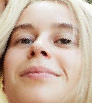

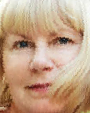

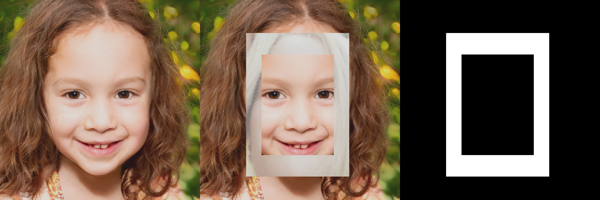

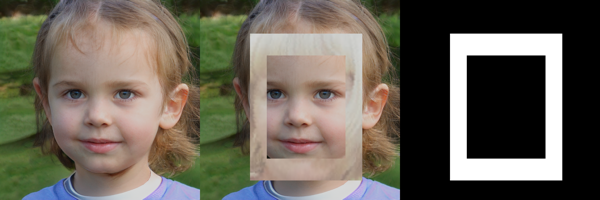

Losses, 0 iteration:: Complete:0.2052, contextual:0.2086,  perceptual original: -6.8980, perceptual (after x0.0005): -0.0034 ,, time: 0.12s
Losses, 200 iteration:: Complete:0.0410, contextual:0.0437,  perceptual original: -5.4165, perceptual (after x0.0005): -0.0027 ,, time: 19.93s
Losses, 400 iteration:: Complete:0.0358, contextual:0.0390,  perceptual original: -6.4953, perceptual (after x0.0005): -0.0032 ,, time: 39.75s
Losses, 600 iteration:: Complete:0.0346, contextual:0.0378,  perceptual original: -6.5333, perceptual (after x0.0005): -0.0033 ,, time: 59.58s
Generation finished for 2 in 79.25 seconds
Generations for different face:


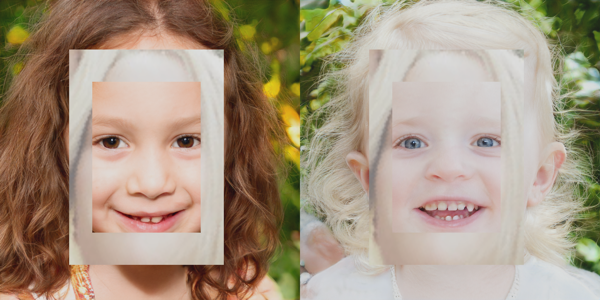

Generations for different face:


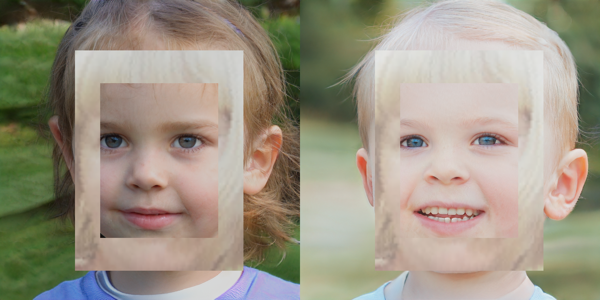

In [93]:
##### Where code will start ####

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  
with open('ffhq.pkl', 'rb') as f:
    D = pickle.load(f)['D'].to(device) 
print(f"G parameters: {sum(p.numel() for p in G.parameters()):,} | D Parameters: {sum(p.numel() for p in D.parameters()):,}")

image_filepath = '16070.jpg'
border_factor = 0.15

# Load MTCNN face detection model
mtcnn = MTCNN(keep_all=True, device=device) #loading face detection model

#  Load image using cv2
original_img = cv2.imread(image_filepath)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# display(ImageOps.contain(Image.fromarray(original_img), (500, 500)))

#finds boxes, landmarks using original image
raw_boxes, raw_landmarks, probs = generate_boxes_landmarks(original_img, mtcnn, device)

# generate gender, race and age for faces in image
face_traits = generate_face_traits(original_img, raw_boxes)

# padding added to image (so rotation does not crop content)
pad_width = max(original_img.shape[:2])//2

# generated detected faces after alignment
cropped_faces = generate_align_rotated_faces(original_img, raw_boxes, raw_landmarks) 

# display generated faces found (not necessary):
generated_faces = [array[0].copy() for array in cropped_faces]
for face in generated_faces:
    display(Image.fromarray(face))

### Inpainting faces ###

training_images, indexes = generate_training_image(cropped_faces, face_traits)

# display training_images faces found (not necessary):
for z, box, real_face_tensor, mask, _ in training_images:
    img = G(z, None) 
    display_and_concat([img, real_face_tensor*mask + img*(1-mask), mask], size = (600, 600))

torch.cuda.empty_cache()
fake_faces, fixed_noise, progress = train_loop(training_images, track_progress = 50, eval_interval = 200)

#Display pre-poisson blended predictions(not necessary)
for index in indexes:
    print("Generations for different face:")
    for z_idx in range(*index):
        z, box, real_face_tensor, mask, _ = training_images[z_idx]
        img = G(z, None) 
        generated_face = fake_faces[z_idx].unsqueeze(dim=0)
        display_and_concat([real_face_tensor*mask + img*(1-mask), real_face_tensor*mask + generated_face*(1-mask)], size = (600, 600))

In [ ]:
generated_faces = poisson_blend_generated_faces(training_images, indexes)

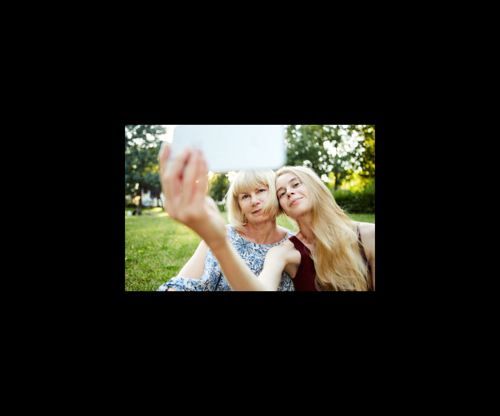

TypeError: ignored

In [95]:
### Placing inpainting predictions back in original image ###

output_img_padded = np.zeros([original_img.shape[0]+2*pad_width, original_img.shape[1]+2*pad_width, 3], dtype = original_img.dtype)
output_img_padded[pad_width:-pad_width, pad_width:-pad_width] = original_img.copy()
display(ImageOps.contain(Image.fromarray(output_img_padded), (500, 500)))

for face_list, (_, box, rotated_box, rotated_img, rotate_angle, face_centre) in zip(generated_faces, cropped_faces):
    #place generated image on rotated image

    rotated_img = rotated_img.copy()
    rotated_img[rotated_box[1]:rotated_box[3], rotated_box[0]:rotated_box[2]] = generated_face
    #rotate back to original alignment
    rotated_img = np.array(Image.fromarray(rotated_img).rotate(-rotate_angle, center=face_centre, expand=False))
    #place generated poisson blended, rotated face back onto original image
    output_img_padded[box[1]:box[3], box[0]:box[2]] = rotated_img[box[1]:box[3], box[0]:box[2]]

output_img = output_img_padded[pad_width:-pad_width, pad_width:-pad_width]
display(Image.fromarray(output_img))


In [101]:
image_list = generated_faces[0] + generated_faces[1]

In [ ]:
image_list[0].shape

In [102]:
np.concatenate(image_list,axis=0)

ValueError: ignored

In [98]:
for img in face_list:
    print(img.shape)

(103, 92, 3)


In [90]:
face_list = [generated_faces[0], generated_faces[1][0]]

In [91]:
for face in face_list:
    display(Image.fromarray(face))